In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import model_selection, naive_bayes, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import itertools
# import catboost
# from catboost import CatBoostClassifier
# import rb

import pickle

In [2]:
np.random.seed(5000)

In [3]:
Corpus = pd.read_csv(r"data/student_evaluation_removal_of_course1.csv",encoding='latin-1')
# Corpus = pd.read_csv(r"data/student_evaluation.csv",encoding='latin-1')

Corpus.head()
# Corpus.Sentiment.unique()

,comment,suggestion,Sentiment
0,This is one of the beginner and best course in...,NO,positive
1,i would like to include the advance version of...,CS,neutral
2,It is an excellent course for Phd students as ...,NO,positive
3,Presenting two papers 1 mid exam + 1 project a...,NO,positive
4,I really learn a lot from this course which wi...,NO,positive


In [4]:
test = pd.read_csv(r"data/course1.csv",encoding='latin-1')
test.head()
# Corpus.Sentiment.unique()

,comment,Predicted_Sentiment,Actual_Sentiment
0,good,NaN,1
1,The course was up to date,NaN,1
2,It is one of the fundamental subjects for Comp...,NaN,1
3,"However, I believe the content of the course w...",NaN,0
4,An excellent course to learn almost every part...,NaN,1


In [5]:
# Step - a : Remove blank rows if any.
test['comment'].dropna(inplace=True)

# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
test['comment'] = [entry.lower() for entry in test['comment']]

# Step - c : Tokenization : In this each entry in the test will be broken into set of words
test['comment']= [word_tokenize(entry) for entry in test['comment']]

# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(test['comment']):
    # Declaring Empty List to store the words that follow the rules for this step
    final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    test.loc[index,'test_final'] = str(final_words)

# print(Final_words)

In [6]:
# Step - a : Remove blank rows if any.
Corpus['comment'].dropna(inplace=True)

# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
Corpus['comment'] = [entry.lower() for entry in Corpus['comment']]

# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['comment']= [word_tokenize(entry) for entry in Corpus['comment']]

# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(Corpus['comment']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index,'text_final'] = str(Final_words)

# print(Final_words)

In [7]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['Sentiment'],test_size=0.2)
X_Test= test['test_final']
Y_Test = test['Actual_Sentiment']
Corpus['Sentiment'].value_counts()
# Corpus['text_final']
# X_Test.shape()
Train_X.describe()
# Test_X.describe()
# Y_Test.describe()

count          486
unique         395
top       ['good']
freq            34
Name: text_final, dtype: object

In [8]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)
# Test_X.describe

In [9]:
print("Comments used for training = ",Train_X.count())
print("Comments used for testing =  ", Test_X.count())


Comments used for training =  486
Comments used for testing =   122


In [27]:
Tfidf_vect = TfidfVectorizer(ngram_range=(1,4))
Tfidf_vect.fit(Corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
print(Train_X_Tfidf)
# type(Test_X_Tfidf)
# print(Train_X_Tfidf)
# vectorizer = CountVectorizer(ngram_range=(2,2))
# Tfidf_vect.fit_transform(Corpus['text_final'])

# print(Tfidf_vect.get_feature_names())

# vectorizer = TfidfVectorizer(ngram_range=(2,2)) # You can still specify n-grams here.
# X = vectorizer.fit_transform(arr)


KeyError: 'text_final'

In [11]:
# print(Train_X_Tfidf)

# Support Vector Machine SVM

In [12]:
# Classifier - Algorithm - SVM

# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  77.04918032786885


## Pipeline model of SVM

In [13]:
#pipeline model SVM
text_clf_SVM= Pipeline([('vect', TfidfVectorizer(ngram_range=(1,4))), 
                      ('clf', SVC(C=1.0, kernel='linear', degree=3, gamma='auto')) ])
# train the model
text_clf_SVM.fit(Train_X,Train_Y)
predicted_svm = text_clf_SVM.predict(Test_X)


# np.mean(predicted_svm == Test_Y)

# Predict the test cases
# test_x = [input()]
# test_x = ['Also the project helped us implement real world applications that is further helpful if we plan to do research in this field.']
# test_x = ['Decision Support Technologies is a required course of IM course. ','no.', 'Please include Field trips.','I think an in class mini-project should be considered to be done step by step in during lectures.']
# test_x = ['Few more application specific contents is needed. ','Good course.', 'Please include Field trips.','I think an in class mini-project should be considered to be done step by step in during lectures.']

# predicted_svm = text_clf_SVM.predict(Test_Y)
# for x in predicted_svm:
#     print(x)

print("SVM Accuracy Score -> ",accuracy_score(predicted_svm, Test_Y)*100)
print("SVM precision score -- > ",precision_score(Test_Y, predicted_svm, average = 'weighted')*100) 

SVM Accuracy Score ->  76.22950819672131
SVM precision score -- >  76.53545636708401


# Classification report

In [14]:
confusion_matrix_result = confusion_matrix(Test_Y, predicted_svm)
print("Confusion matrix \n",confusion_matrix_result)
print("\n Classification report \n",classification_report(Test_Y, predicted_svm))

print("\n SVM accuracy score -- > ",accuracy_score(Test_Y, predicted_svm)*100) 
print("\n SVM precision score -- > ",precision_score(Test_Y, predicted_svm, average = 'weighted')*100) 

Confusion matrix 
 [[51 11]
 [18 42]]

 Classification report 
              precision    recall  f1-score   support

          0       0.74      0.82      0.78        62
          1       0.79      0.70      0.74        60

avg / total       0.77      0.76      0.76       122


 SVM accuracy score -- >  76.22950819672131

 SVM precision score -- >  76.53545636708401


### Saving test result in CSV file


In [15]:
# #make the predictions with trained model and submit the predictions.

# predicted_svm_save = text_clf_SVM.predict(X_Test)

# confusion_matrix_result = confusion_matrix(Y_Test, predicted_svm_save)
# print("Confusion matrix \n",confusion_matrix_result)
# print("\n Classification report \n",classification_report(Y_Test, predicted_svm_save))

# print("\n SVM accuracy score -- > ",accuracy_score(Y_Test, predicted_svm_save)*100) 
# print("\n SVM precision score -- > ",precision_score(Y_Test, predicted_svm_save, average = 'weighted')*100) 

# test['Sentiment'] = predicted_svm_save
# submission = test[["comment","Sentiment","Actual"]]
# submission.to_csv("data/results/SVM_course1.csv", index = False)

In [16]:
#make the predictions with trained model and submit the predictions.

predicted_svm_save = text_clf_SVM.predict(X_Test)

confusion_matrix_result = confusion_matrix(Y_Test, predicted_svm_save)
print("Confusion matrix \n",confusion_matrix_result)
print("\n Classification report \n",classification_report(Y_Test, predicted_svm_save))

print("\n SVM accuracy score -- > ",accuracy_score(Y_Test, predicted_svm_save)*100) 
print("\n SVM precision score -- > ",precision_score(Y_Test, predicted_svm_save, average = 'weighted')*100) 

test['Predicted_Sentiment'] = predicted_svm_save
submission = test[["comment","Predicted_Sentiment","Actual_Sentiment"]]
submission.to_csv("data/results/SVM_course1.csv", index = False)

Confusion matrix 
 [[12  2]
 [ 6 13]]

 Classification report 
              precision    recall  f1-score   support

          0       0.67      0.86      0.75        14
          1       0.87      0.68      0.76        19

avg / total       0.78      0.76      0.76        33


 SVM accuracy score -- >  75.75757575757575

 SVM precision score -- >  78.18181818181819


In [17]:
# Corpus = pd.read_csv(r"data/student_evaluation.csv",encoding='latin-1')
# # Corpus.head()
# print("Sentiment:" , test.Sentiment.unique())
# print("Sentiment: [positive, neutral/negative]")

# print (test['Sentiment'].value_counts())
# test['Sentiment'].value_counts().plot(kind="bar")

# plt.title('Course 5 classification result ')
# plt.xlabel('Sentiment')
# plt.ylabel('Count')

# plt.show()

Sentiment: [1 0]
Sentiment: [positive, neutral/negative]
0    18
1    15
Name: Predicted_Sentiment, dtype: int64


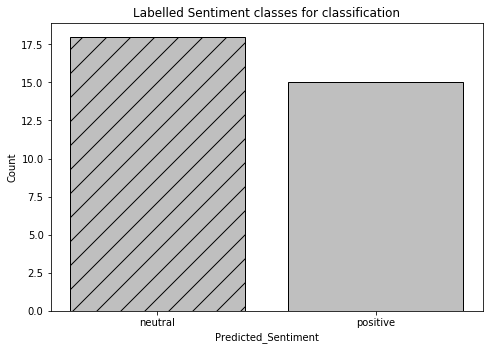

In [18]:
Corpus = pd.read_csv(r"data/student_evaluation.csv",encoding='latin-1')
# Corpus.head()

print("Sentiment:" , test.Predicted_Sentiment.unique())

print("Sentiment: [positive, neutral/negative]")
print (test['Predicted_Sentiment'].value_counts())

a = []
a = test['Predicted_Sentiment'].value_counts()
# print(a[0],a[1])

x = []
x = Corpus.Sentiment.unique()
X = x[0] 
Y = x[1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(Y, a[0], color = (0.5,0.5,0.5,0.5) ,edgecolor='black', hatch="/")
ax.bar(X, a[1], color = (0.5,0.5,0.5,0.5) ,edgecolor='black')
# ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)


plt.title('Labelled Sentiment classes for classification')
plt.xlabel('Predicted_Sentiment')
plt.ylabel('Count')
plt.show()
# plt.figure()

In [19]:
# classes = ["IS","CS", "neutral","positive"]

# plt.figure()
# plt.imshow(confusion_matrix_result, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title("Confusion Matrix - Text Clasiffication")
# plt.colorbar()
# tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, classes, rotation=45)
# plt.yticks(tick_marks, classes)

# text_format = 'd'
# thresh = confusion_matrix_result.max() / 2.
# for row, column in itertools.product(range(confusion_matrix_result.shape[0]), range(confusion_matrix_result.shape[1])):
#     plt.text(column, row, format(confusion_matrix_result[row, column], text_format),
#              horizontalalignment="center",
#              color="white" if confusion_matrix_result[row, column] > thresh else "black")

# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.tight_layout()

# plt.show()

In [20]:
# from sklearn.model_selection import GridSearchCV
# parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
#              'tfidf__use_idf': (True, False),
#              'clf-svm__alpha': (1e-2, 1e-3),
# }
# gs_clf_svm = GridSearchCV(text_clf_SVM, parameters_svm, n_jobs=-1)
# gs_clf_svm = gs_clf_svm.fit(Train_X_Tfidf,Train_Y)
# gs_clf_svm.best_score_
# # gs_clf_svm.best_params_

In [21]:
# # save the model
# # https://stackabuse.com/text-classification-with-python-and-scikit-learn/
# with open('text_classifier', 'wb') as picklefile:
#     pickle.dump(SVM,picklefile)

# # to load the model use the following
# with open('text_classifier', 'rb') as training_model:
#     model = pickle.load(training_model)

## without pipline

In [22]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
predictions_SVM = SVM.predict(Test_X_Tfidf)

print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  77.04918032786885


In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

predictions_SVM = SVM.predict(Test_X_Tfidf)
confusion_matrix_result = confusion_matrix(Test_Y, predictions_SVM)
print("Confusion matrix \n",confusion_matrix_result)
print("\n Classification report \n",classification_report(Test_Y, predictions_SVM))
print("\n SVM precision score -- > ",precision_score(Test_Y, predictions_SVM, average = 'weighted')*100) 

Confusion matrix 
 [[57  5]
 [23 37]]

 Classification report 
              precision    recall  f1-score   support

          0       0.71      0.92      0.80        62
          1       0.88      0.62      0.73        60

avg / total       0.80      0.77      0.76       122


 SVM precision score -- >  79.53454332552693


In [25]:
# classes = ["suggestion", "neutral","positive"]

# plt.figure()
# plt.imshow(confusion_matrix_result, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title("Confusion Matrix - Text Clasiffication")
# plt.colorbar()
# tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, classes, rotation=45)
# plt.yticks(tick_marks, classes)

# text_format = 'd'
# thresh = confusion_matrix_result.max() / 2.
# for row, column in itertools.product(range(confusion_matrix_result.shape[0]), range(confusion_matrix_result.shape[1])):
#     plt.text(column, row, format(confusion_matrix_result[row, column], text_format),
#              horizontalalignment="center",
#              color="white" if confusion_matrix_result[row, column] > thresh else "black")

# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.tight_layout()

# plt.show()

In [26]:
# # Classifier - Algorithm - SVM
# # fit the training dataset on the classifier
# SVM = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')
# SVM.fit(Train_X_Tfidf,Train_Y)
# # predict the labels on validation dataset
# predictions_SVM = SVM.predict(Test_X_Tfidf)
# # Use accuracy_score function to get the accuracy
# print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)